<h1 align=center><font size = 8>Situación Covid-19 en Galicia</font></h1>

El propósito de este notebook es capturar de la <a href="https://coronavirus.sergas.gal/datos/#/gl-ES/undefined">web del Sergas</a> los datos actualizados de la situación de Galicia frente al Covid-19, y posteriormente realizar algunos análisis básicos, guardando los resultados en directorios.

Para los cálculos basados en el número de habitantes se emplea un fichero csv obteniendo mediante otro notebook, llamado _Población Areas_ y también disponible en el repositorio de GitHub. Se debe de tener en cuenta que en este análisis se trabaja con áreas sanitarias y no con ayuntamientos. Pese a que todos los nombres de las áreas sanitarias coinciden también con nombres de ayuntamientos, en ellas se encuentran englobadas otras comarcas y ayuntamientos limítrofes y próximas.

In [1]:
from classes.covid19galicia import covid19galicia
import pandas as pd

# 1. Importación de datos

Creamos la clase que maneja los datos de la web del Sergas e importamos solamente aquellos que son necesarios para las futuras gráficas.

In [2]:
galicia = covid19galicia()
casos_activos = galicia.getCifrasTotais()
infectados_fecha = galicia.getInfeccionesPorFecha()
camas = galicia.getOcupacionCamas()
fallecidos = galicia.getActivosCuradosFallecidos()
inc14 = galicia.getIncidenciaConcello()

Ultima actualización: 2021-07-06


Podemos visualizar los datos del último día:

In [3]:
total = galicia.getCifrasTotais()
print('En las últimas 24h hubo {} casos en Galicia'.format(total['Casos_Confirmados_PDIA_Ultimas24h'].sum()))
total

En las últimas 24h hubo 366 casos en Galicia


,Fecha,Area_Sanitaria,Casos_Totais,Casos_Confirmados_PDIA_Ultimas24h,Pacientes_Sin_Alta,Pacientes_Con_Alta,Camas_Ocupadas_HOS,Camas_Ocupadas_UCI,Probas_Realizadas_PCR,Probas_Realizadas_Non_PDIA,Exitus,Probas_Antixenos_Realizadas
0,2021-07-06,A Coruña,31544,58,669,30289,20,3,541651,155001,601,191079
1,2021-07-06,Ferrol,8831,7,108,8500,2,2,153005,62438,217,16972
2,2021-07-06,Lugo,13428,43,314,12892,3,1,264214,137564,217,44509
3,2021-07-06,Ourense,16313,72,399,15497,3,0,270913,133443,418,78417
4,2021-07-06,Pontevedra,15026,39,580,14265,11,5,253716,94270,181,87829
5,2021-07-06,Santiago,20432,40,275,19804,2,1,378318,147559,365,103836
6,2021-07-06,Vigo,25898,107,572,24895,5,0,529519,272181,439,73913


# 2. Análisis

## 2.1. Casos activos - Total por área sanitaria

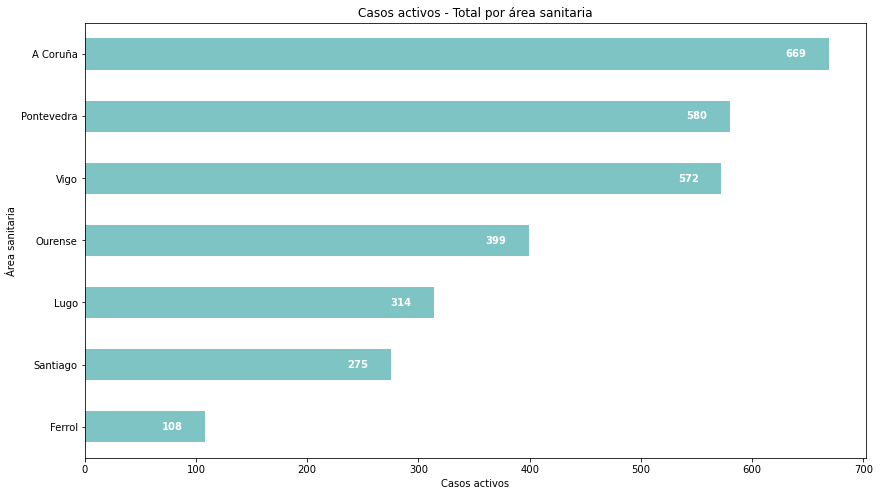

In [4]:
galicia.plotCasosActivos(casos_activos, cienmil=False)

## 2.2. Casos activos - Porcentaje por área sanitaria

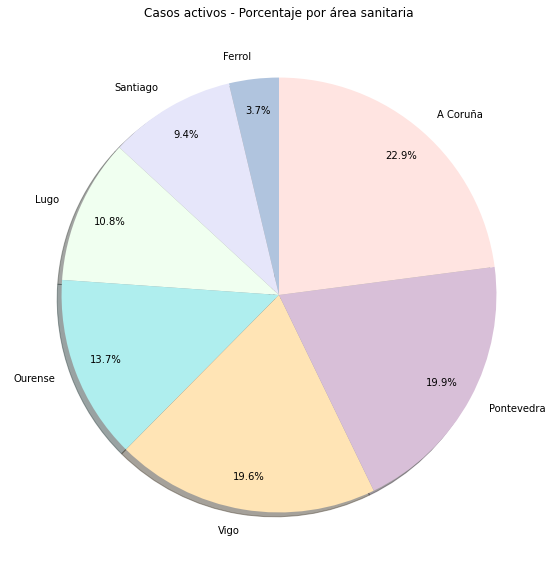

In [5]:
galicia.plotPorcentajeAreas(casos_activos)

## 2.3. Positivos

### 2.3.1. Evolución positivos acumulados últimos 7 días

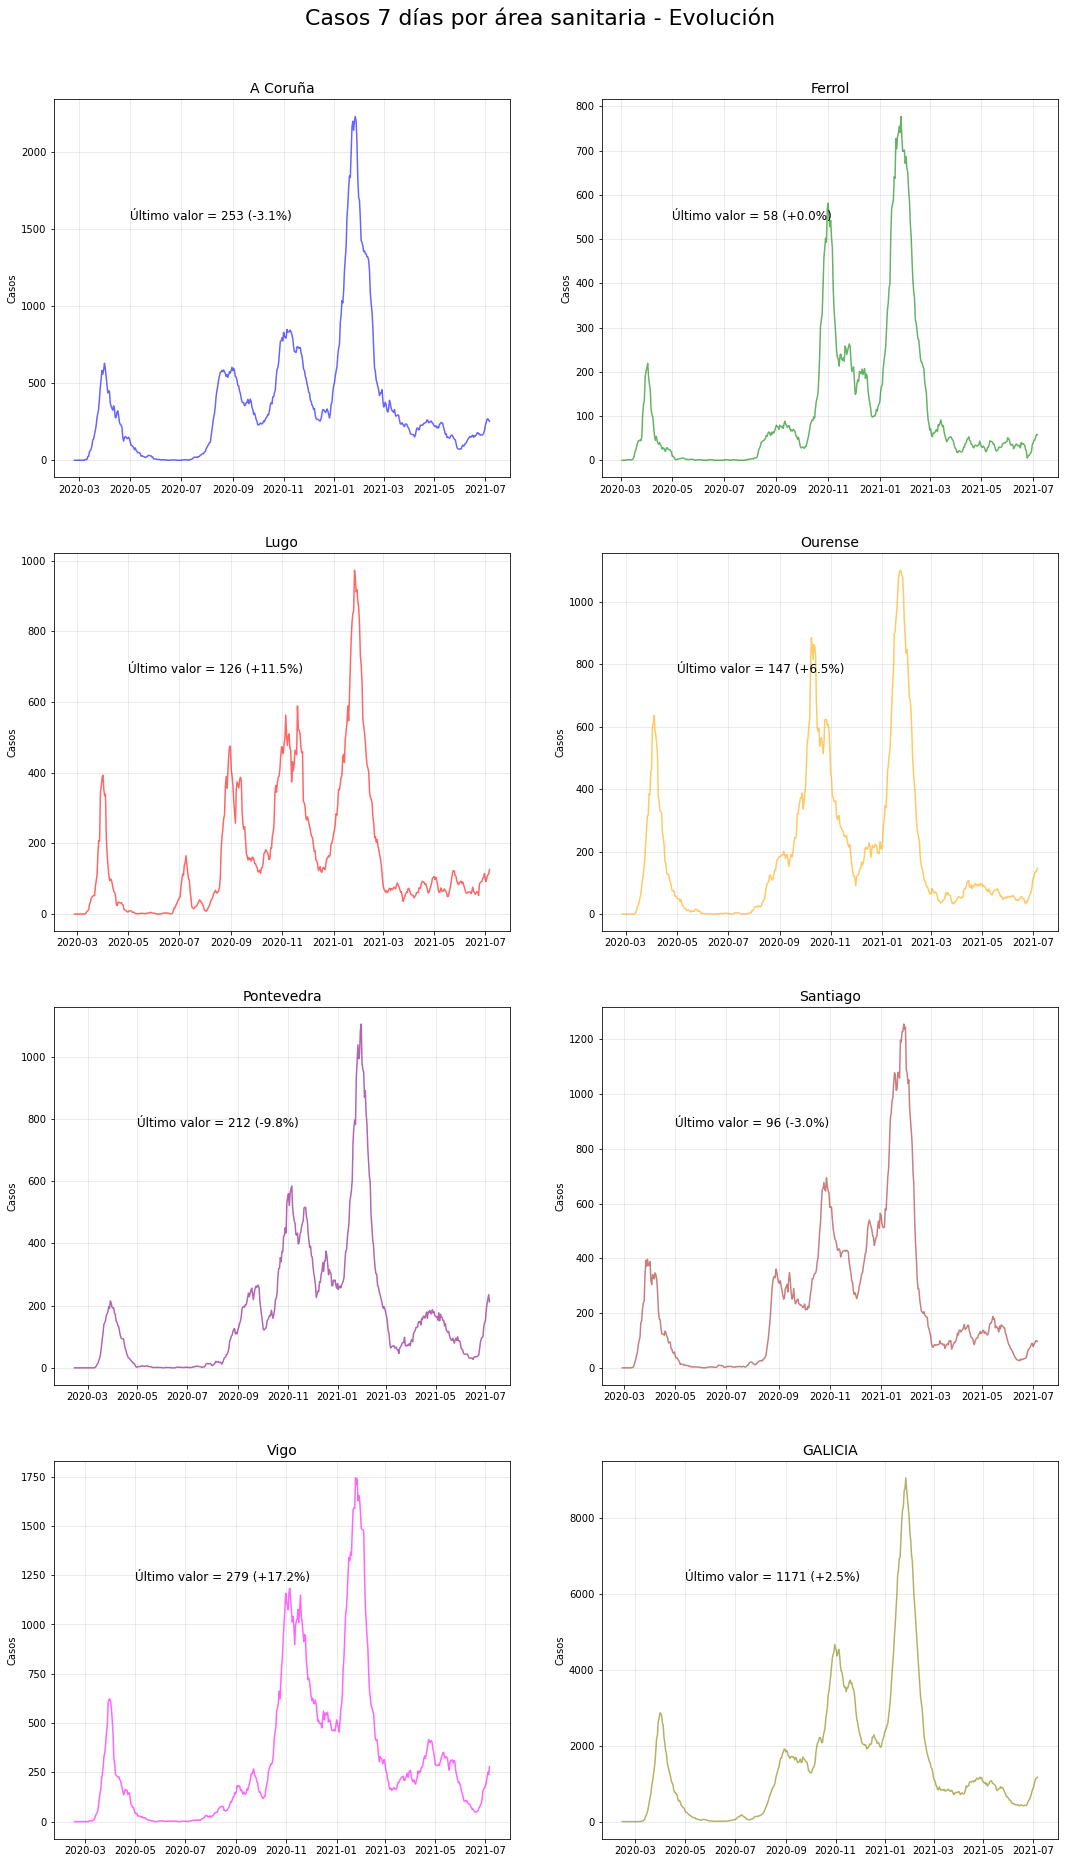

In [6]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=7)

### 2.3.2. Comparativo positivos acumulados últimos 7 días

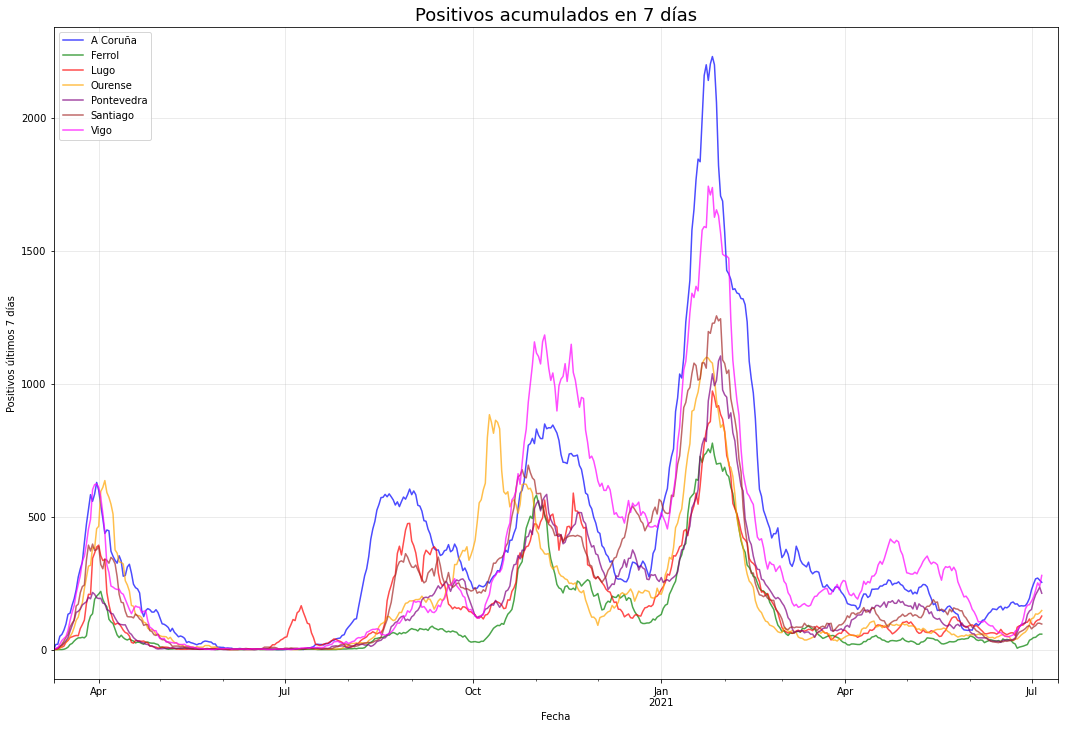

In [7]:
galicia.plotCombinado(infectados_fecha)

### 2.3.3. Principales ciudades - Incidencia 14 días / 100.000 habitantes

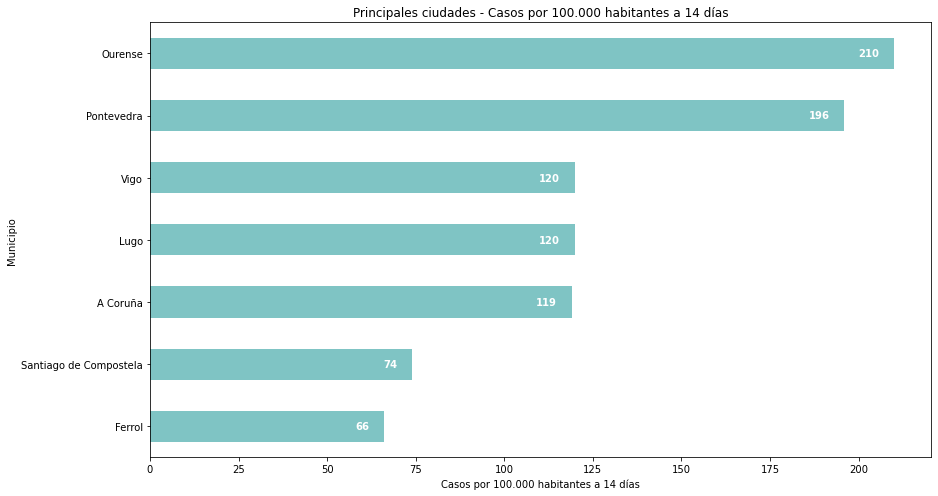

In [8]:
galicia.plotIncidenciaAcumulada(inc14, 'ciudades')

### 2.3.4. Top 10 municipios con mayor incidencia 14 días / 100.000 habitantes

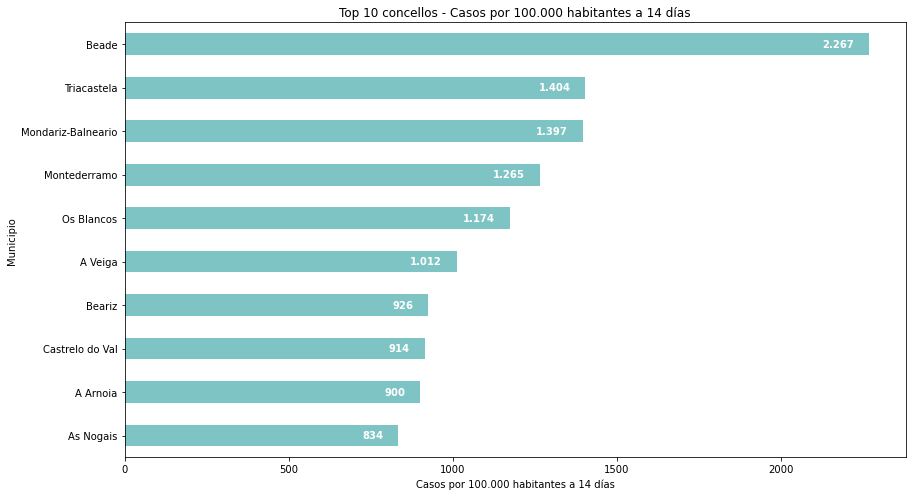

In [9]:
galicia.plotIncidenciaAcumulada(inc14, 'top10')

## 2.4. Evolución PCR acumuladas 7 días

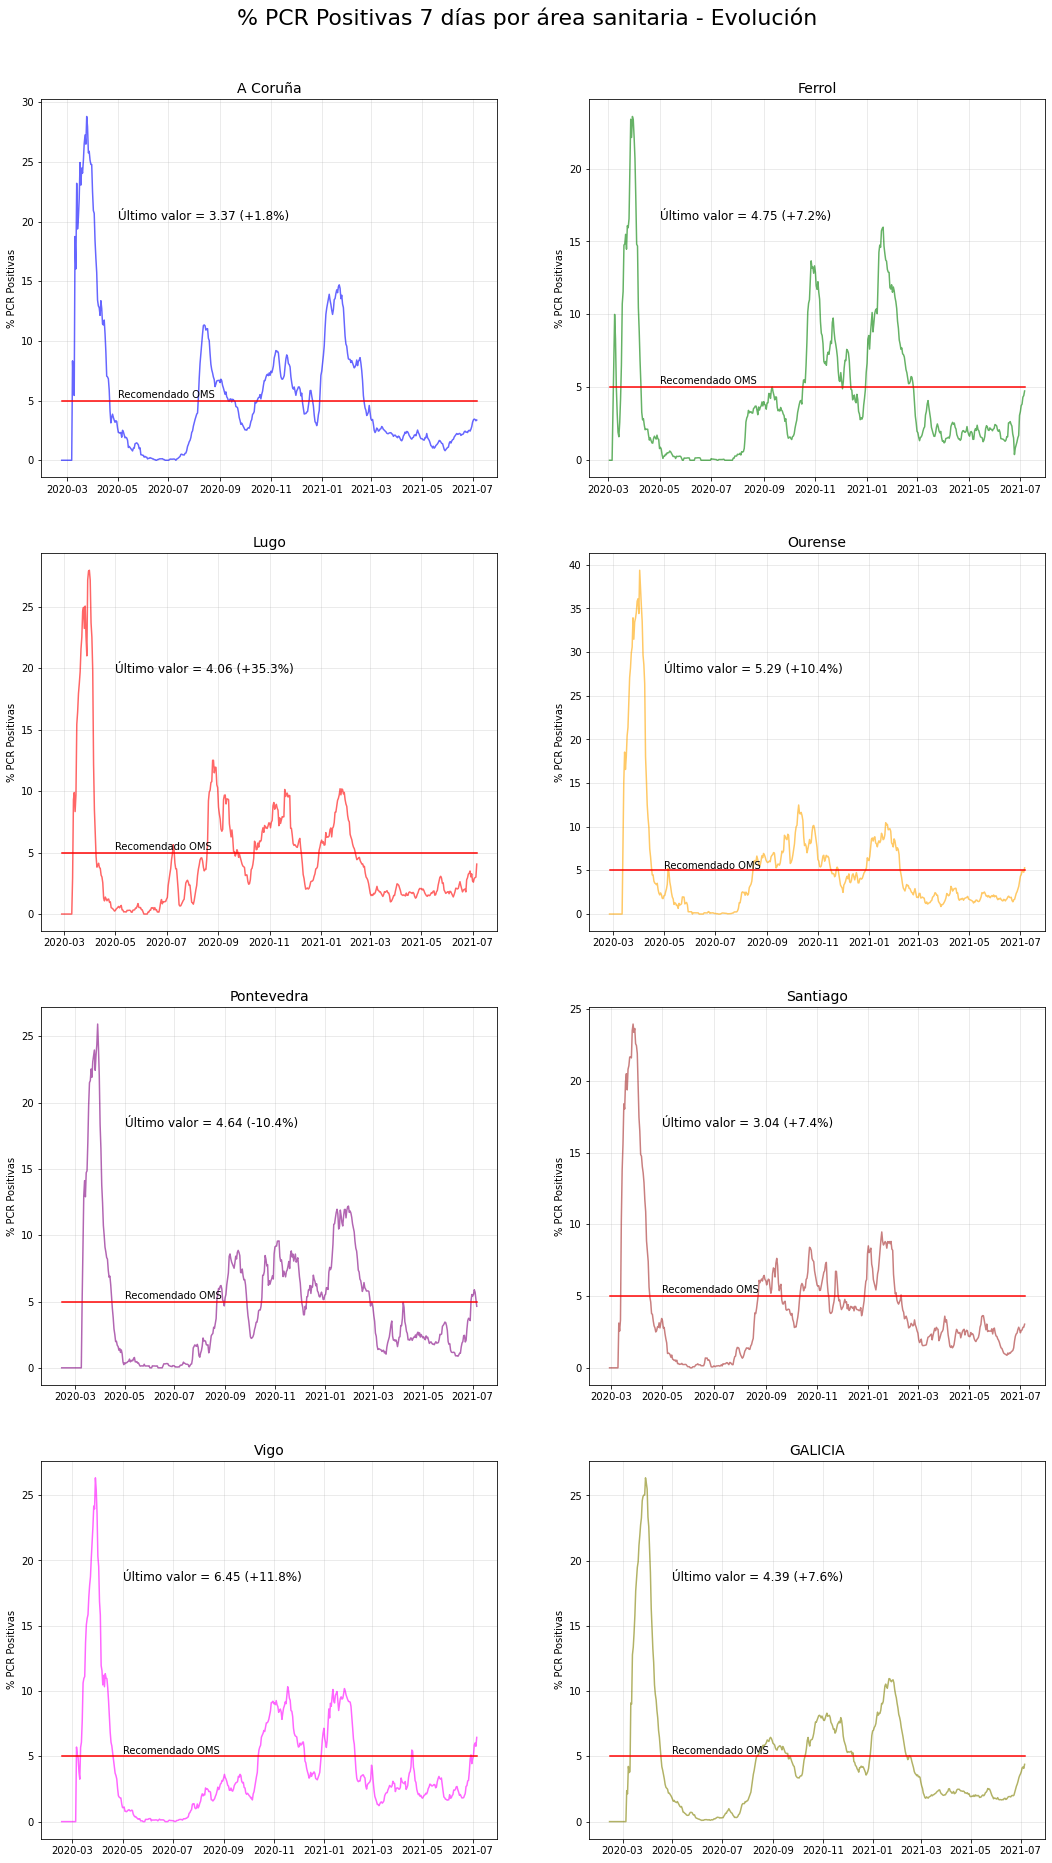

In [10]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=7)

## 2.5. Tendencias

### 2.5.1. Clara tendencia en aumento

In [11]:
inc14 = inc14[inc14['Tendencia'].notna()]
inc14 = inc14[inc14['Casos7'] != inc14['Casos']]
inc14.sort_values('Tendencia', ascending=False)
incrementos = list(inc14['Municipio'][inc14['Tendencia'] > 10])
incrementos.sort()
print(*incrementos, sep=', ')

A Coruña, A Estrada, A Illa de Arousa, A Laracha, Arteixo, Barbadás, Boiro, Caldas de Reis, Cambados, Carballo, Chantada, Culleredo, Curtis, Ferrol, Gondomar, Lugo, Marín, Meis, Miño, Moaña, Nigrán, O Carballiño, O Porriño, Oia, Oleiros, Ourense, Ponteareas, Redondela, Ribadavia, Sada, Santiago de Compostela, Sanxenxo, Teo, Vigo, Vilagarcía de Arousa, Vilanova de Arousa


### 2.5.2. Clara tendencia en descenso

In [12]:
descensos = list(inc14['Municipio'][inc14['Tendencia'] < -10])
descensos.sort()
print(*descensos, sep=', ')

A Merca, A Pastoriza, A Pobra de Trives, Ames, Arzúa, Betanzos, Burela, Cabana de Bergantiños, Carnota, Castroverde, Frades, Lousame, Mondariz-Balneario, O Rosal, O Vicedo, Outeiro de Rei, Poio, Sobrado, Soutomaior, Val do Dubra, Valdoviño, Vilasantar, Xunqueira de Ambía


## 2.6. Ocupación actual de camas

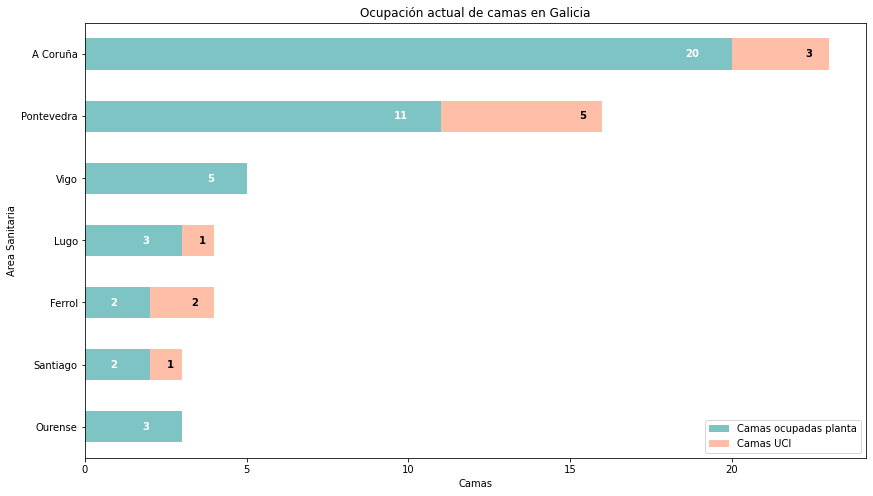

In [13]:
galicia.plotOcupacionCamas(camas)

## 2.7. Fallecidos

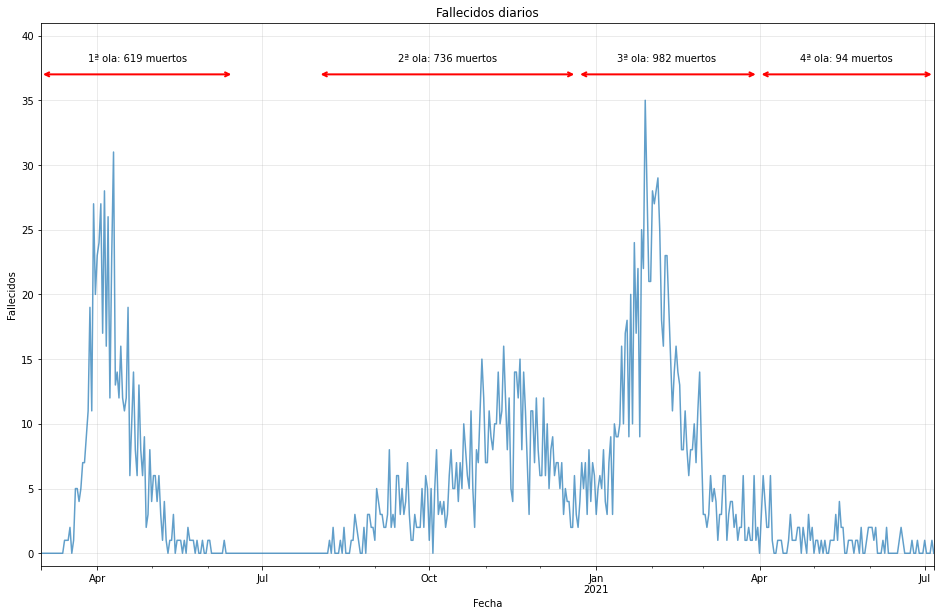

In [14]:
galicia.plotFallecidos(fallecidos)